Лабораторная работа №3

In [127]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from matplotlib import pylab as plt

# 1. Загрузите данные ex3data1.mat из файла.

mat = loadmat('ex3data1.mat')
learn_data: pd.DataFrame = pd.DataFrame(np.hstack((mat['X'], mat['y'])), columns=("X", "y"))
validation_data = pd.DataFrame(np.hstack((mat['Xval'], mat['yval'])), columns=("X", "y"))
test_data = pd.DataFrame(np.hstack((mat['Xtest'], mat['ytest'])), columns=("X", "y"))


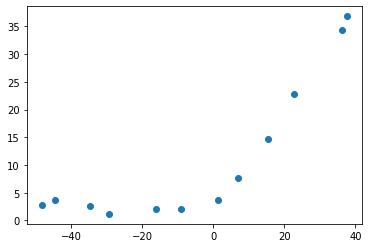

In [128]:
# 2. Постройте график, где по осям откладываются X и y из обучающей выборки.
plt.scatter(learn_data.X, learn_data.y)

plt.show()

In [129]:
# 3. Реализуйте функцию стоимости потерь для линейной регрессии с L2-регуляризацией.
def hypothesis(x, *thetas):
    return x @ np.array([thetas]).T

def cost_function(thetas, l, data):
    column_x = data.iloc[:, list(range(0, data.columns.size - 1))].to_numpy()
    column_y = data.iloc[:, -1].to_numpy().reshape(1, len(data)).T
    return (((hypothesis(column_x, *thetas) - column_y) ** 2).sum() + l*(np.array(thetas[1:])**2).sum())/ (2 * len(column_x))

In [130]:
# 4. Реализуйте функцию градиентного спуска для линейной регрессии с L2-регуляризацией.

def gradient_descent_with_lambda(alfa, l, data, args, iterations = 10**3):
    thetas = np.array(args)
    size = len(data)
    y = data.iloc[:,-1].to_numpy().reshape(1, size).T
    x = data.iloc[:, list(range(0, data.columns.size - 1))].to_numpy()
    while iterations > 0:
        thetas_for_l = thetas.copy()
        thetas_for_l[0] = 0
        thetas_for_hypothesis = thetas.tolist()
        thetas = thetas - alfa * (np.sum((hypothesis(x, *thetas_for_hypothesis) - y) * x, axis=0) / size + l * thetas_for_l / size)
        iterations -= 1
    return thetas.tolist()

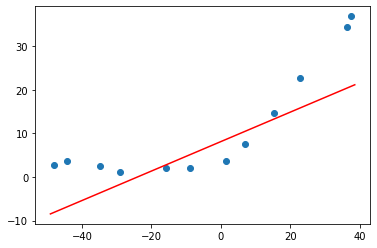

Регуляризация не работает, потому что в формуле градиентного спуска часть где действует регуляризация умножается на 0


In [131]:
# 5. Постройте модель линейной регрессии с коэффициентом регуляризации 0 и постройте график полученной функции совместно с графиком.
data = learn_data.copy()
data.insert(0, "X0", 1)
theta_first_result, theta_second_result = gradient_descent_with_lambda(0.001, 0, data, [0, 0])
min_x, max_x = ((learn_data[["X"]].min() - 1), (learn_data[["X"]].max() + 1))
plt.scatter(learn_data[["X"]], learn_data[["y"]])
plt.plot([min_x,max_x],[theta_first_result + theta_second_result * min_x,theta_first_result + theta_second_result * max_x], "r")
plt.show()

print("Регуляризация не работает, потому что в формуле градиентного спуска часть где действует регуляризация умножается на 0")

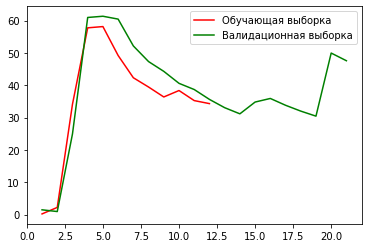

In [132]:
# 6. Постройте график процесса обучения (learning curves) для обучающей и валидационной выборки.

leaning_curves = []
for i in range(1, len(data) + 1):
    leaning_curves.append(cost_function((theta_first_result, theta_second_result), 0, data[:i]))
plt.plot(list(range(1, len(data) + 1)), leaning_curves, "r", label= "Обучающая выборка")
plt.legend()
leaning_curves.clear()

data = validation_data.copy()
data.insert(0, "X0", 1)
for i in range(1, len(data) + 1):
    leaning_curves.append(cost_function((theta_first_result, theta_second_result), 0, data[:i]))
plt.plot(list(range(1, len(data) + 1)), leaning_curves, "g", label= "Валидационная выборка")
plt.legend()

plt.show()

In [133]:
# 7. Реализуйте функцию добавления p - 1 новых признаков в обучающую выборку (X2, X3, X4, …, Xp).

def add_features(p: int, X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    for i in range(2, p + 1):
        X.insert(i - 1, f"X^{i}", X.iloc[:, 0] ** i)
    return X

In [134]:
# 8. Поскольку в данной задаче будет использован полином высокой степени, то необходимо перед обучением произвести нормализацию признаков.

full_data = learn_data.copy().append(validation_data).append(test_data)
mean = np.array(full_data.mean(axis=0))
s = np.array(np.std(full_data.to_numpy().T, axis=1))
normalized_learn_data = pd.DataFrame((learn_data.to_numpy() - mean) / s, columns=learn_data.columns)
normalized_validation_data = pd.DataFrame((validation_data.to_numpy() - mean) / s, columns=validation_data.columns)
normalized_test_data = pd.DataFrame((test_data.to_numpy() - mean) / s, columns=test_data.columns)

In [135]:
# 9. Обучите модель с коэффициентом регуляризации 0 и p = 8.

data = add_features(8, normalized_learn_data.copy()[["X"]])
data.insert(0, "X^0", 1)
data.insert(data.columns.size, "y", normalized_learn_data[["y"]])
start_thetas = [0]*9
theta_results = gradient_descent_with_lambda(0.01, 0, data, start_thetas, iterations=10**3)
thetas = theta_results

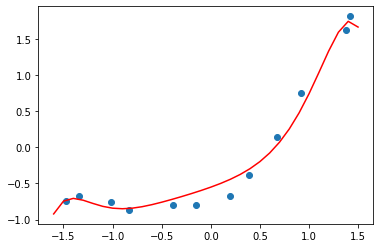

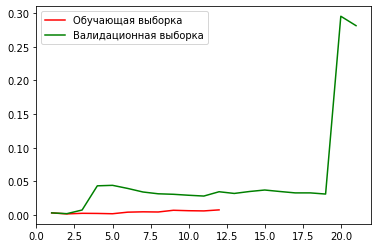

Модель переобучена


In [136]:
# 10. Постройте график модели, совмещенный с обучающей выборкой, а также график процесса обучения.
x_for_prediction = add_features(8, pd.DataFrame(np.arange(-1.6, 1.6, 0.1), columns=["X"]))
x_for_prediction.insert(0, "X^0", 1)

def build_model():
    prediction = hypothesis(x_for_prediction.to_numpy(), *theta_results)
    plt.scatter(normalized_learn_data[["X"]], normalized_learn_data[["y"]])
    plt.plot(x_for_prediction[["X"]].to_numpy().tolist(), prediction.tolist(), "r")
    plt.show()

build_model()

leaning_curves = []
for i in range(1, len(data) + 1):
    leaning_curves.append(cost_function(theta_results, 0, data[:i]))
plt.plot(list(range(1, len(data) + 1)), leaning_curves, "r", label="Обучающая выборка")
plt.legend()
leaning_curves.clear()

extended_normalized_validation_data = add_features(8, normalized_validation_data.copy()[["X"]])
extended_normalized_validation_data.insert(0, "X^0", 1)
extended_normalized_validation_data.insert(extended_normalized_validation_data.columns.size, "y", normalized_validation_data[["y"]])
for i in range(1, len(extended_normalized_validation_data) + 1):
    leaning_curves.append(cost_function(theta_results, 0, extended_normalized_validation_data[:i]))
plt.plot(list(range(1, len(extended_normalized_validation_data) + 1)), leaning_curves, "g", label="Валидационная выборка")
plt.legend()

plt.show()

print("Модель переобучена")

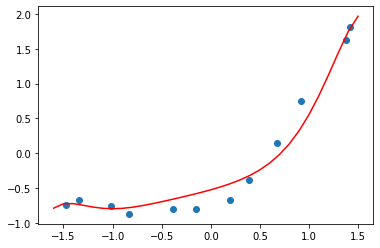

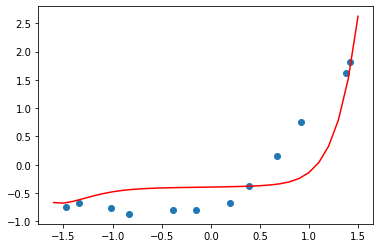

Модель получается недообученой, однако уменьшен разброс


In [137]:
# 11.Постройте графики из пункта 10 для моделей с коэффициентами регуляризации 1 и 100.


theta_results = gradient_descent_with_lambda(0.01, 1, data, start_thetas, iterations = 10**3)
build_model()

theta_results = gradient_descent_with_lambda(0.01, 100, data, start_thetas, iterations = 10**3)
build_model()

print("Модель получается недообученой, однако уменьшен разброс")

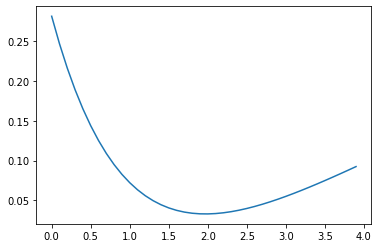

Минимальная ошибка при коэффициенте регуляризации 2.0


In [138]:
# 12. С помощью валидационной выборки подберите коэффиент регуляризации, который позволяет достичь наименьшей ошибки.

lambdas = np.arange(0, 4, 1e-1)
results = []

def cost_function_vectorized(l):
    theta = gradient_descent_with_lambda(0.01, l, data, start_thetas, iterations=10**3)
    return cost_function(theta, l, extended_normalized_validation_data)

cost_results = np.vectorize(cost_function_vectorized)(lambdas)
l = lambdas[cost_results.argmin()]
plt.plot(lambdas, cost_results)
plt.show()

print("Минимальная ошибка при коэффициенте регуляризации", l)


In [139]:
# 13. Вычислите ошибку (потерю) на контрольной выборке.

data = add_features(8, normalized_test_data.copy()[["X"]])
data.insert(0, "X^0", 1)
data.insert(data.columns.size, "y", normalized_test_data[["y"]])

print("Ошибка на контрольной выборке", cost_function(thetas, l, data))

Ошибка на контрольной выборке 0.21391009691820423
